<a href="https://colab.research.google.com/github/MicroprocessorX069/Collaborative-Filtering-for-medical-history/blob/master/DAE_Pytorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [0]:
import torch 
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import os
from PIL import Image
import glob
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import random
from bokeh.io import curdoc, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen
import time
import pickle
from torchsummary import summary

#parameters
batch_size=100
train_split=0.8
num_epochs=5

#input
data_dir="data"
inp_width=300
inp_height=256
inp_channels=3

#generator
ngf=2
ndf=2

#discriminator
ndf=2

#To copy


In [0]:
# from __future__ import absolute_import, division, print_function, unicode_literals
# !pip install tensorflow-gpu==2.0
# import tensorflow as tf
# import numpy as np
# import os
# import datetime
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# print("Tensorflow version: ",tf.__version__)

In [0]:
#!pip install tensorflow --upgrade --force-reinstall

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import os
import datetime
import random

http://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=41202

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#paths
root_dir="/content/drive/My Drive/Projects/Collaborative filtering/"
fcodes_dataset_path="/content/drive/My Drive/Projects/Collaborative filtering/Datasets/fcodesbucket edited - fcodesbucket.csv"
version="dae-2"
ckpt_dir="/content/drive/My Drive/Projects/Collaborative filtering/Implementations/lstm-2/checkpoints/"

In [0]:
text=open(fcodes_dataset_path).read()
print("Text is {} characters long".format(len(text)))

Text is 381175 characters long


In [0]:
text

In [0]:
histories=[h for h in text.split('\n')]
print("Data has {} patient histories".format(len(histories)))
n_patients=len(histories)

Data has 6237 patient histories


In [0]:
n_patients=len(histories)

real_data=[]
for history in histories:
  real_data.append([symptom for symptom in history.split(',')])
for history in real_data:
  while "" in history:
    history.remove("")
  history.append("End")

real_data[0]

['H269', 'D259', 'F067', 'End']

Sorting the symptoms, except the last 'end'

In [0]:
for i,_ in enumerate(real_data):
  real_data[i]=sorted(real_data[i][:-1])+[real_data[i][-1]]

Splitting each symptom in to 3 levels
e.g. A423 as A, 42, 3

Splitting one history into multiple sub histories
H, 20, 4, G,12,6 into
[H],[H,20],[H,20,4],[H,20,4,G]

Min length has to be 4.
i.e. One whole symptom has to be there (Not split, whole with all 3 levels) 


In [0]:
data=[]
for history in real_data:
  hist=[]
  for s in history:
    if s!="End":
      try:
        hist.extend([s[0],s[1:3],s[3]])
      except:
        hist.extend([s[0],s[1:3],'0'])
    else:
      hist.append(s)
  data.append(hist)
data[0]



['D', '25', '9', 'F', '06', '7', 'H', '26', '9', 'End']

In [0]:
data[0]

['H', '26', '9', 'D', '25', '9', 'F', '06', '7', 'End']

Combining all histories to one

In [0]:
text=[]
for history in data:
  text.extend(history)


Each characted mapped as a no.

In [0]:
vocab=sorted(set(text))
print("There are {} unique characters".format(len(vocab)))
char2int={c:i for i,c in enumerate(vocab)}
int2char=np.array(vocab)
print("Vector:\n")
for char,_ in zip(char2int,range(8)):
  print(' {:4s}: {:3d},'.format(repr(char), char2int[char]))

There are 132 unique characters
Vector:

 '0' :   0,
 '00':   1,
 '01':   2,
 '02':   3,
 '03':   4,
 '04':   5,
 '05':   6,
 '06':   7,


In [0]:
char2int['End']

115

##Data analysis

In [0]:
def flatten2D(grid):
  a=[]
  for x in grid:
    a.extend(x)
  return a

In [0]:

from collections import Counter
import operator
def get_top10(aug_data):
  flatten_aug_data=flatten2D(aug_data)
  counter_levels=Counter(flatten_aug_data)
  percent_levels=sorted([[i, (counter_levels[i] / len(flatten_aug_data) * 100.0)] for i in counter_levels],reverse=True,key=operator.itemgetter(1))
  return percent_levels[1:10]

In [0]:
print("Top 10 Symptoms")
print(get_top10(real_data))
print("Top 10 symptoms levels")
a=get_top10(aug_data)


Top 10 Symptoms
[['R074', 1.533902411749357], ['F329', 1.2412867633354456], ['F103', 1.0008573452119134], ['R104', 0.926305587654229], ['R55', 0.892757296753271], ['F102', 0.8834383270585604], ['F100', 0.8815745331196183], ['T391', 0.8032951876840496], ['R073', 0.6989227271032915]]
Top 10 symptoms levels


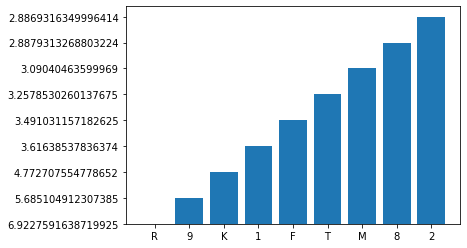

In [0]:
import matplotlib.pyplot as plt
top10_levels=np.array(get_top10(aug_data))
#top10_levels[:,1].astype(int)
y_pos = np.arange(len(top10_levels[:,0]))
 
# Create bars
plt.bar(y_pos, top10_levels[:,1])
 
# Create names on the x-axis
plt.xticks(y_pos, top10_levels[:,0])
 
# Show graphic
plt.show()

#plt.bar(top10_levels[:,0],top10_levels[:,1])
top10_symptoms=np.array(get_top10(real_data))
#plt.bar(top10_symptoms[:,0],top10_symptoms[:,1])

Mapping each of the level codes in histories to nos.

In [0]:
int_data=[]
for history in data:
  int_data.append(np.array([char2int[level_code] for level_code in history],dtype=np.int32))
int_data=np.array(int_data)
print ('{}\n mapped to integers:\n {}'.format(repr(data[0]), int_data[0]))

['D', '25', '9', 'F', '06', '7', 'H', '26', '9', 'End']
 mapped to integers:
 [113  28  99 116   7  77 118  29  99 115]


Creating training and validation sets

In [0]:
n_histories=len(data)

BLinding it with no 420

In [0]:
#Find the max length of history
max_history_len=0
for history in int_data:
  max_history_len=max(len(history),max_history_len)
print("Longest history of a patient: ",max_history_len)

In [0]:
def random_blinding(history):
  n=len(history)
  history=list(map(lambda x:x/132,history))
  y_history=history.copy()
  req_len=95-n
  res=[]
  for it in range(2*n):
    temp=history.copy()
    
    blind_indices = random.sample(range(0, n), round(n*0.3)) 
    for i in blind_indices:
      temp[i]=1   
    #Padding shoudl be done here. since, 
    
    temp=np.append(temp,[(char2int['End'])/132]*req_len)
    y_history=np.append(history.copy(),[(char2int['End'])/132]*req_len)
    
    res.append([temp,y_history])
  return res

This is complete blinding. But needs to be optimized as the RAM limits the operation. Cool no problem as of now!

In [0]:
from itertools import combinations 
BLIND_PERCENT=0.2
def get_blind_histories(history):
  n=len(history)
  y_history,res=history,[]
  comb = combinations(list(range(0,n)), int(n*BLIND_PERCENT)) 
  print(comb)
  for c in list(comb):
      history=y_history 
      for index in list(c):
        history[index]=420
      res.append([history,y_history])
  return res

In [231]:
print("Blinding the integer codes of diseases with no. 420")
print("BLINDING PERCENT 30%.\n ")

aug_int_data=[]
for history in int_data:
  aug_int_data.extend(random_blinding(history))
n_aug_histories=len(aug_int_data)
aug_int_data=np.array(aug_int_data)

print("Length of complete data points:",len(aug_int_data)) # blinded data
print("Example of a blinded data pointL: ",aug_int_data[0])

Blinding the integer codes of diseases with no. 420
BLINDING PERCENT 30%.
 
Length of complete data points: 296976
Example of a blinded data pointL:  [[1.         0.21212121 0.75       0.87878788 0.0530303  1.
  1.         0.21969697 0.75       0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121212 0.87121212 0.87121212
  0.87121212 0.87121212 0.87121212 0.87121

In [170]:
len(aug_int_data[3][1])

95

##From Tensorflow doc - Creating dataset
https://www.tensorflow.org/tutorials/load_data/text

Pytorch GRU with attention maps
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py

##Pytorch code starts here.

In [0]:
class listDataset(torch.utils.data.Dataset):
  def __init__(self,aug_int_data):
    self.aug_int_data=aug_int_data
     
    self.data_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485],[0.229]) # need to normalize . How to do this will find out!.
    ]) # oh my god! I also need to pad the input! Cool. # shoudl I do it before? would be easy.
    
  def __getitem__(self,index):
    
    blind_input=(self.aug_int_data[index][0]) # Rememeber each data point is a numpy array. Indexing might be different
    real_input=(self.aug_int_data[index][1]) #need to put the data variable. 
    return blind_input,real_input
  
  def __len__(self):
    return len(self.aug_int_data)
  


In [0]:
dataset=listDataset(aug_int_data)

Splitting into training and validation set.

In [233]:
print("Splitting the dataloader into training and validation..\n")
train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
batch_size=1
train_dataset, val_dataset=torch.utils.data.random_split(dataset,[train_size,val_size])
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
num_batches=len(train_dataloader)
val_dataloader=torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
print("Length of train dataset :{}, of val dataset:{}".format(
    len(train_dataset),len(val_dataset)
))

Splitting the dataloader into training and validation..

Length of train dataset :237580, of val dataset:59396


Model

In [0]:
class Autoencoder(nn.Module):
  def __init__(self,input_size,hidden_size,latent_rep_size):
    super(Autoencoder,self).__init__()
    self.fc1= nn.Linear(input_size,hidden_size)
    self.relu1=nn.ReLU()
    self.fc2=nn.Linear(hidden_size,latent_rep_size)
    self.relu2=nn.ReLU()
    self.fc3=nn.Linear(latent_rep_size,hidden_size)
    self.relu3=nn.ReLU()
    self.fc4= nn.Linear(hidden_size,input_size)
    self.t=nn.Tanh()
    
  def forward(self,x):
    #print(x.shape)
    out=self.fc1(x)
    #out=self.relu1(out)
    out=self.fc2(out)
    #print(out.shape)
    #out=self.relu2(out)
    #print(out.shape)
    out=self.fc3(out)
    #out=self.relu3(out)
    out=self.fc4(out)
    return self.t(out).abs()

In [0]:
#parameters
lr=0.02
beta1=0.5
beta2=0.999
L1_lambda=1

In [234]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("Training on device: ", device)
input_size=95
hidden_size=55
latent_rep_size=15
model=Autoencoder(input_size,hidden_size, latent_rep_size).to(device)
print(model)

#Loss and optimizer
criterion=nn.MSELoss().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=lr,betas=(beta1,beta2))

Training on device:  cuda:0
Autoencoder(
  (fc1): Linear(in_features=95, out_features=55, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=55, out_features=15, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=15, out_features=55, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=55, out_features=95, bias=True)
  (t): Tanh()
)


In [235]:
total_step=len(train_dataloader)
#model.train()
for epoch in range(num_epochs):
  for i,(blind_vector,real_vector) in enumerate(train_dataloader):
    blind_vector=blind_vector.to(device).float()
    real_vector=real_vector.to(device).float() 
    
    #forward pass
    #print(real_vector)
    outputs=model(blind_vector)
    loss=criterion(outputs,real_vector)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(i+1)%10000==0:
      print('Epoch [{}/{}], Step[{}/{}],Loss:{:.4f}'
           .format(epoch+1,num_epochs,i+1,total_step,loss.item()))

Epoch [1/5], Step[10000/237580],Loss:0.3491
Epoch [1/5], Step[20000/237580],Loss:0.0298
Epoch [1/5], Step[30000/237580],Loss:0.3593
Epoch [1/5], Step[40000/237580],Loss:0.0611
Epoch [1/5], Step[50000/237580],Loss:0.0936
Epoch [1/5], Step[60000/237580],Loss:0.1131
Epoch [1/5], Step[70000/237580],Loss:0.1200
Epoch [1/5], Step[80000/237580],Loss:0.0332
Epoch [1/5], Step[90000/237580],Loss:0.1496
Epoch [1/5], Step[100000/237580],Loss:0.0927
Epoch [1/5], Step[110000/237580],Loss:0.0674
Epoch [1/5], Step[120000/237580],Loss:0.2047
Epoch [1/5], Step[130000/237580],Loss:0.0845
Epoch [1/5], Step[140000/237580],Loss:0.0692
Epoch [1/5], Step[150000/237580],Loss:0.0482
Epoch [1/5], Step[160000/237580],Loss:0.2314
Epoch [1/5], Step[170000/237580],Loss:0.1131
Epoch [1/5], Step[180000/237580],Loss:0.0630
Epoch [1/5], Step[190000/237580],Loss:0.2732
Epoch [1/5], Step[200000/237580],Loss:0.2851
Epoch [1/5], Step[210000/237580],Loss:0.2047
Epoch [1/5], Step[220000/237580],Loss:0.1157
Epoch [1/5], Step[2

KeyboardInterrupt: ignored

In [0]:
criterion(model(blind_vector),real_vector)
pred=model(blind_vector)

In [221]:
criterion(pred[0][92],real_vector[0][92])

tensor(12996., device='cuda:0', grad_fn=<MseLossBackward>)

In [229]:
def decode_disease(vector):
  

tensor(115., device='cuda:0')

In [0]:
import pickle
print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
  
torch.save(G.state_dict(), 'generator_param.pkl')
torch.save(D.state_dict(), 'discriminator_param.pkl')
with open('train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

utils.show_train_hist(train_hist, save=True, path="/content/drive/My Drive/Lumentum/NAVA_ocr/" + 'train_hist.png')